In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import os
path = os.getcwd()
files = os.listdir(path)
files

['.ipynb_checkpoints',
 '1.Logistic Regression - Banking (Customer Subscribe or Not).ipynb',
 '2.Decision Tree - Banking (Customer Subscribe or Not).ipynb',
 '3.Random Forest - Banking (Customer Subscribe or Not).ipynb',
 'Banking.csv',
 'Log_ROC.png']

In [2]:
df = pd.read_csv('Banking.csv')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [3]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [4]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp_var_rate      float64
cons_price_idx    float64
cons_conf_idx     float64
euribor3m         float64
nr_employed       float64
y                   int64
dtype: object

In [5]:
df.nunique()

age                 78
job                 12
marital              4
education            8
default              3
housing              3
loan                 3
contact              2
month               10
day_of_week          5
duration          1544
campaign            42
pdays               27
previous             8
poutcome             3
emp_var_rate        10
cons_price_idx      26
cons_conf_idx       26
euribor3m          316
nr_employed         11
y                    2
dtype: int64

In [6]:
df['education'].value_counts()

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64

In [7]:
df['education'] = np.where(df['education'].isin(['basic.4y','basic.6y','basic.9y']), 'Basic', df['education'])
df['education'].value_counts()

Basic                  12513
university.degree      12168
high.school             9515
professional.course     5243
unknown                 1731
illiterate                18
Name: education, dtype: int64

### Create dummy variables

In [8]:
df1 = pd.get_dummies(df, columns=['job','marital','education','default','housing','loan',
                                    'contact','month','day_of_week','poutcome'], drop_first=True)

## Data Exploration

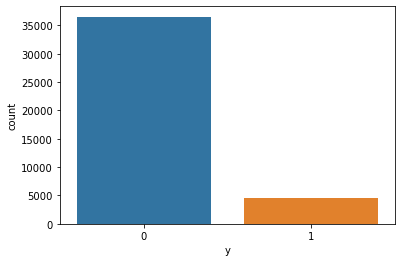

In [9]:
sns.countplot(x='y', data=df1)
plt.show()

In [10]:
df1['y'].value_counts(normalize=True)*100

0    88.734583
1    11.265417
Name: y, dtype: float64

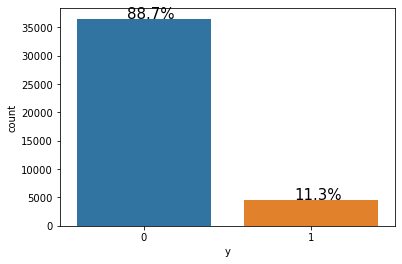

In [11]:
total = float(len(df1))
ax = sns.countplot(x='y', data=df1)

for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height()/total*100)
    x = p.get_x() + p.get_width()/ 1 - 0.5
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x,y), size=15)
plt.show() 

### Divide into X and Y

In [12]:
X = df1.loc[:,df1.columns!='y']
y = df1.loc[:,df1.columns=='y']

print(X.shape)
print(y.shape)

(41188, 51)
(41188, 1)


### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)

### Handling Imbalance Data - SMOTE
- There 3 methods we can use to handle imbalance data set
  - SMOTE - Over sampling technique generates synthetic data points of minority class
  - SMOTEENN - Over sampling then under sampling 
  - SMOTETOmek - Over sampling then under sampling 

https://imbalanced-learn.org/stable/auto_examples/index.html#general-examples

- Using SMOTE noisy sample can be generated. E.g where different classes can not be very well separate. Hence, it can be benificial to apply an under sampling algorithm to clean the noisy samples. Please see above link
 
- SMOTEENN is better then SMOTETOmek

In [14]:
# !pip install imblearn 
# First run above command incase SMOTE is not loading

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=10)
smote_X_train, smote_y_train = smote.fit_resample(X_train, y_train)

In [15]:
print(y_train['y'].value_counts())
print(smote_y_train['y'].value_counts())

0    29238
1     3712
Name: y, dtype: int64
0    29238
1    29238
Name: y, dtype: int64


## Modeling

### Selecting best ccp_alpha, max_leaf_nodes, max_depth

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(smote_X_train, smote_y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

ccp_alphas_new = [i for i in ccp_alphas if i>.001]

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

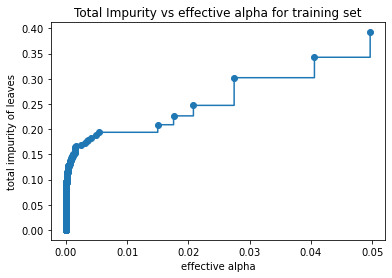

In [19]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [20]:
clfs = []
for ccp_alpha in ccp_alphas_new:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(smote_X_train, smote_y_train)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.10770567072245507


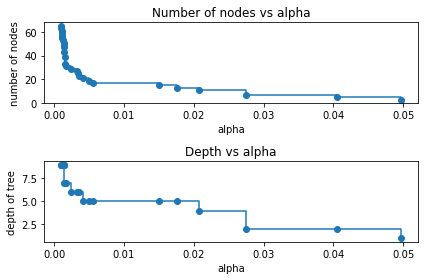

In [21]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas_new[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

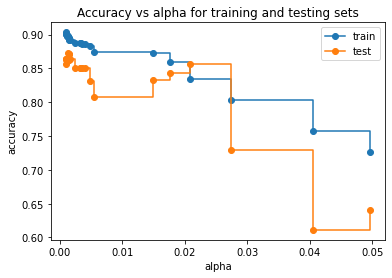

In [22]:
train_scores = [clf.score(smote_X_train, smote_y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

### Hyperparameter Optimisation - GridSearchCV
- https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python
- https://www.kaggle.com/funxexcel/p2-logistic-regression-hyperparameter-tuning
- Based on best parameter of GridSearch CV, run again logistic regression model and make prediction and play with Type-I & 
Type-II error


- Difference between GridSearchCV & RamdomizedSearchCV
 - https://www.quora.com/What-is-the-difference-between-random-search-and-grid-search-for-hyperparameter-optimization

### Hyperparameter Optimisation - RandomizedSearchCV

In [31]:
%%time

from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()

param_randomCV = [{'criterion':['gini','entropy'], 'max_depth':[3,4,5], 'min_samples_split':[2,3,4,5], 
                   'min_samples_leaf':[1,2,3], 'ccp_alpha':[.015, .017, .018 ,.02], 'splitter':['best','random'], 
                   'min_impurity_decrease':[.001], 'max_leaf_nodes':[17,18,19,20]}]

randomCV = RandomizedSearchCV(estimator=classifier, param_distributions=param_randomCV, cv=5, scoring='accuracy', random_state=10)
best_randomCV = randomCV.fit(smote_X_train, smote_y_train)

print(best_randomCV.best_estimator_)
print('--------------------------------------------')
print(best_randomCV.best_params_)
print('--------------------------------------------')
print(best_randomCV.best_score_)

DecisionTreeClassifier(ccp_alpha=0.017, criterion='entropy', max_depth=4,
                       max_leaf_nodes=20, min_impurity_decrease=0.001)
--------------------------------------------
{'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_impurity_decrease': 0.001, 'max_leaf_nodes': 20, 'max_depth': 4, 'criterion': 'entropy', 'ccp_alpha': 0.017}
--------------------------------------------
0.8688184455105803
Wall time: 9.3 s


In [32]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(ccp_alpha=0.017, criterion='entropy', max_depth=4,
                       max_leaf_nodes=20, min_impurity_decrease=0.001)
model.fit(smote_X_train, smote_y_train)

DecisionTreeClassifier(ccp_alpha=0.017, criterion='entropy', max_depth=4,
                       max_leaf_nodes=20, min_impurity_decrease=0.001)

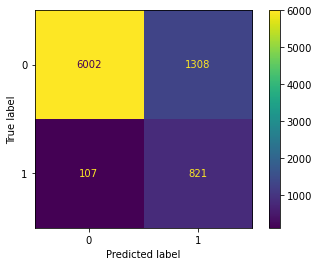

In [33]:
from sklearn.metrics import plot_confusion_matrix
dis = plot_confusion_matrix(model, X_test, y_test)

In [34]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7310
           1       0.39      0.88      0.54       928

    accuracy                           0.83      8238
   macro avg       0.68      0.85      0.72      8238
weighted avg       0.92      0.83      0.85      8238



### Adjust threshold value to play with Type-I & Type-II error

In [37]:
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred_prob_thres = np.where(y_pred_prob > 0.5, 1, 0)

print(confusion_matrix(y_test, y_pred_prob_thres))
print(classification_report(y_test, y_pred_prob_thres))

[[6002 1308]
 [ 107  821]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89      7310
           1       0.39      0.88      0.54       928

    accuracy                           0.83      8238
   macro avg       0.68      0.85      0.72      8238
weighted avg       0.92      0.83      0.85      8238



### ROC Curve

Accuracy: 0.83
AUC: 0.91


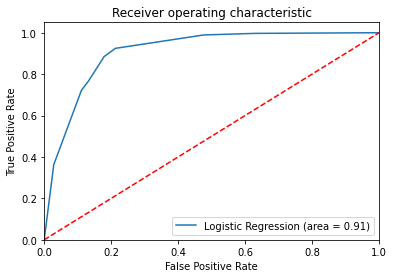

In [38]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, log_loss

logit_roc_auc = roc_auc_score(y_test, model.predict(X_test)) # Need to check how it is different from auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

print('Accuracy:', np.round(accuracy_score(y_test, y_pred_prob_thres), 2))
print('AUC:', np.round(auc(fpr, tpr),2))
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % np.round(auc(fpr, tpr),2))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

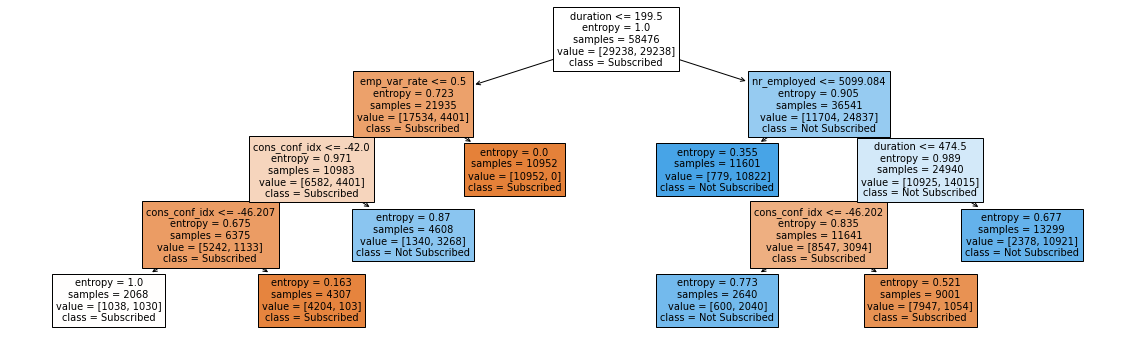

In [39]:
from sklearn.tree import plot_tree, export_text

features = list(smote_X_train.columns)
classes = ['Subscribed', 'Not Subscribed']

plt.figure(figsize=(20,6))
plot_tree(model, feature_names=features, class_names=classes, filled=True);

In [40]:
print(export_text(model, feature_names=features, show_weights=True))

|--- duration <= 199.50
|   |--- emp_var_rate <= 0.50
|   |   |--- cons_conf_idx <= -42.00
|   |   |   |--- cons_conf_idx <= -46.21
|   |   |   |   |--- weights: [1038.00, 1030.00] class: 0
|   |   |   |--- cons_conf_idx >  -46.21
|   |   |   |   |--- weights: [4204.00, 103.00] class: 0
|   |   |--- cons_conf_idx >  -42.00
|   |   |   |--- weights: [1340.00, 3268.00] class: 1
|   |--- emp_var_rate >  0.50
|   |   |--- weights: [10952.00, 0.00] class: 0
|--- duration >  199.50
|   |--- nr_employed <= 5099.08
|   |   |--- weights: [779.00, 10822.00] class: 1
|   |--- nr_employed >  5099.08
|   |   |--- duration <= 474.50
|   |   |   |--- cons_conf_idx <= -46.20
|   |   |   |   |--- weights: [600.00, 2040.00] class: 1
|   |   |   |--- cons_conf_idx >  -46.20
|   |   |   |   |--- weights: [7947.00, 1054.00] class: 0
|   |   |--- duration >  474.50
|   |   |   |--- weights: [2378.00, 10921.00] class: 1

